✅ All libraries imported successfully
📊 Data Loaded:
   Training: (112, 16), Test: (28, 16)
✅ Base models loaded: ['knn', 'decision_tree', 'random_forest', 'svr', 'ridge']
Ensemble Models Created:
   BAGGING RANDOM FOREST
   BOOSTING GRADIENT BOOST
   STACKING RIDGE
TRAINING ENSEMBLE MODELS WITH 10-FOLD CROSS-VALIDATION

[MODEL] Training BAGGING_RANDOM_FOREST with 10-fold CV...
   ✅ BAGGING RANDOM FOREST Trained
      10-Fold CV RMSE: 2.2414
      Test RMSE: 3.4971
      Test R²: -0.2028

[MODEL] Training BOOSTING_GRADIENT_BOOST with 10-fold CV...
   ✅ BOOSTING GRADIENT BOOST Trained
      10-Fold CV RMSE: 2.2552
      Test RMSE: 3.2932
      Test R²: -0.0666

[MODEL] Training STACKING_RIDGE with 10-fold CV...
   ✅ STACKING RIDGE Trained
      10-Fold CV RMSE: 2.2048
      Test RMSE: 3.3221
      Test R²: -0.0854

ENSEMBLE MODEL PERFORMANCE SUMMARY


,Model,CV RMSE,Test RMSE,Test MAE,Test R²
0,BAGGING RANDOM FOREST,2.2414,3.4971,2.1213,-0.2028
1,BOOSTING GRADIENT BOOST,2.2552,3.2932,2.2202,-0.0666
2,STACKING RIDGE,2.2048,3.3221,2.0302,-0.0854



DETAILED ENSEMBLE TEST RESULTS

Rank  Model                          Test RMSE    CV RMSE      R²        
----------------------------------------------------------------------
1     BOOSTING GRADIENT BOOST        3.2932       2.2552       -0.0666   
2     STACKING RIDGE                 3.3221       2.2048       -0.0854   
3     BAGGING RANDOM FOREST          3.4971       2.2414       -0.2028   

Best Ensemble Model: BOOSTING GRADIENT BOOST
   Test RMSE: 3.2932
   Test R²: -0.0666
   10-Fold CV RMSE: 2.2552

ENSEMBLE TEST PREDICTIONS ANALYSIS

BAGGING RANDOM FOREST
   Total Test Samples: 28
   Test RMSE: 3.4971
   Test MAE:  2.1213
   Test R²:   -0.2028
   10-Fold CV RMSE: 2.2414
   Mean Residual: -1.3083
   Std Residual:  3.2432

   Error Statistics:
   Mean Absolute Error: 2.1213
   Median Absolute Error: 1.3846
   Max Error: 12.6327
   Min Error: 0.1810

   First 10 predictions:
 Actual  Predicted     Error  Absolute_Error  Percent_Error
   77.0  77.421665 -0.421665        0.421665

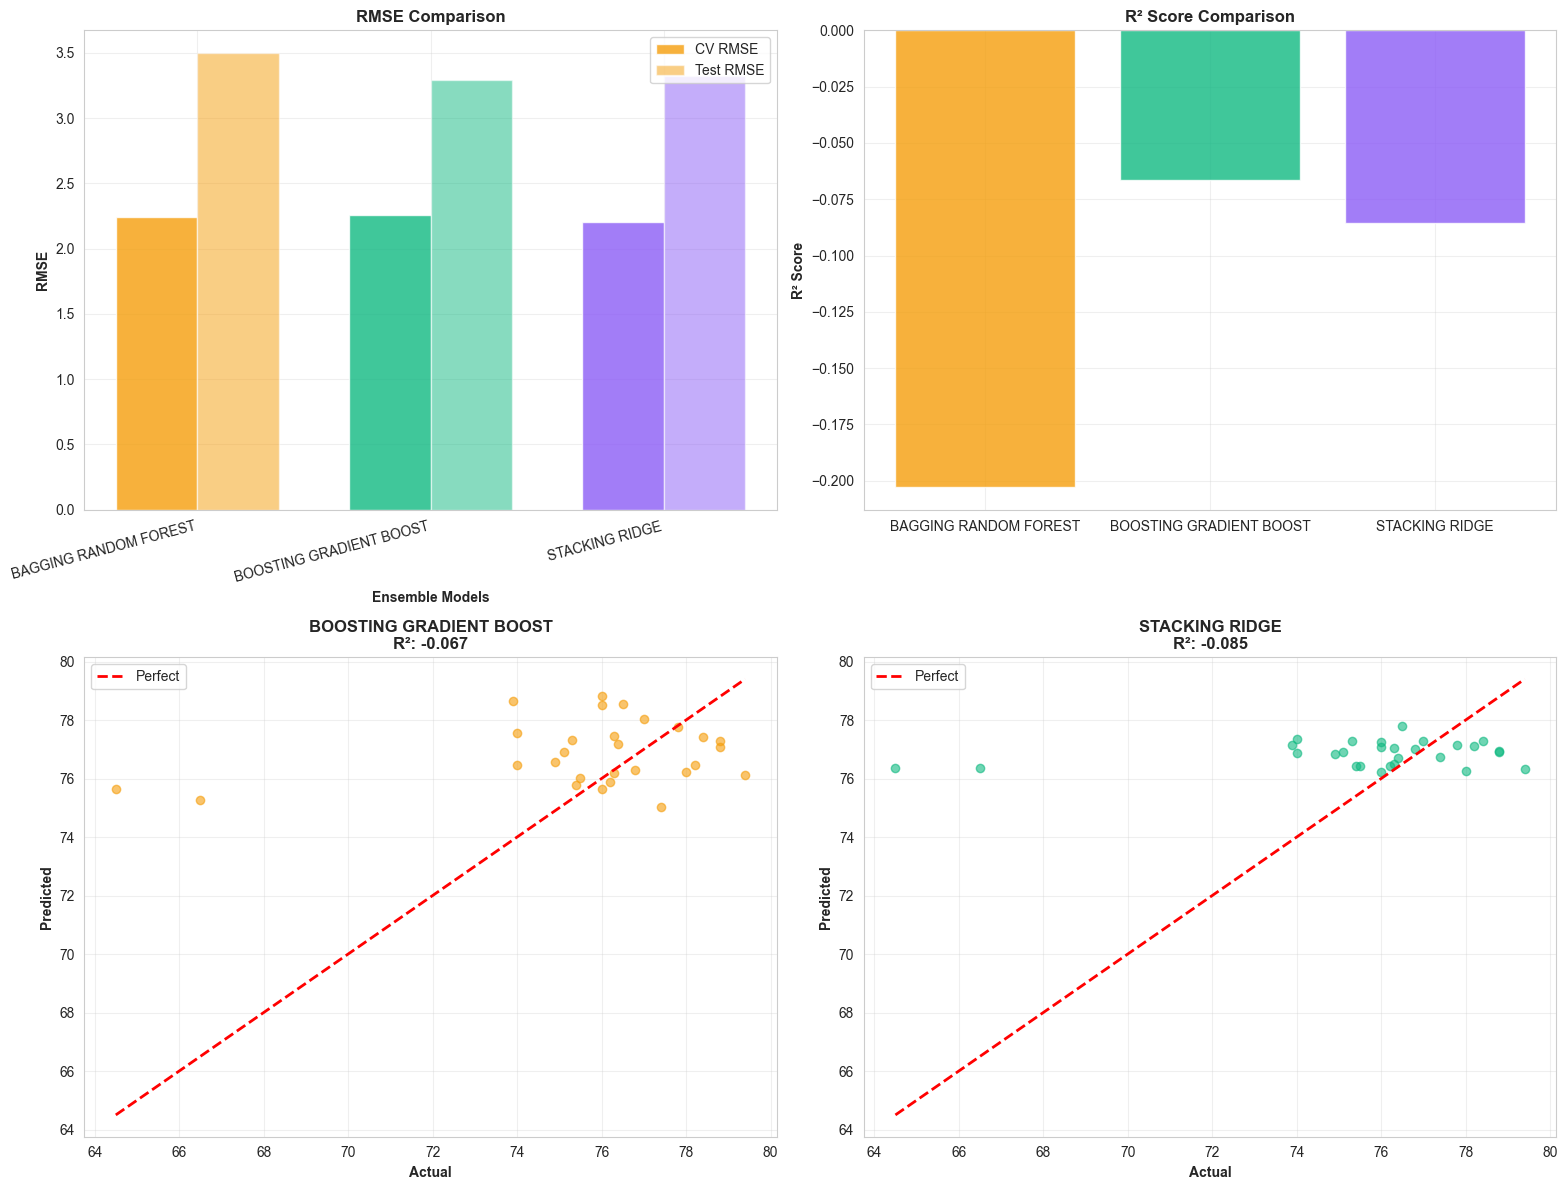


💾 Ensemble models saved to ../saved_ensemble_models_dataset/

ENSEMBLE vs BASE MODELS COMPARISON

    Type                   Model     RMSE      MAE
    Base                   RIDGE 3.272426 2.067766
Ensemble BOOSTING GRADIENT BOOST 3.293248 2.220226
Ensemble          STACKING RIDGE 3.322076 2.030160
    Base                     SVR 3.332079 2.036660
    Base                     KNN 3.358209 2.143087
    Base           RANDOM_FOREST 3.442720 2.070164
    Base           DECISION_TREE 3.489851 2.084345
Ensemble   BAGGING RANDOM FOREST 3.497099 2.121320


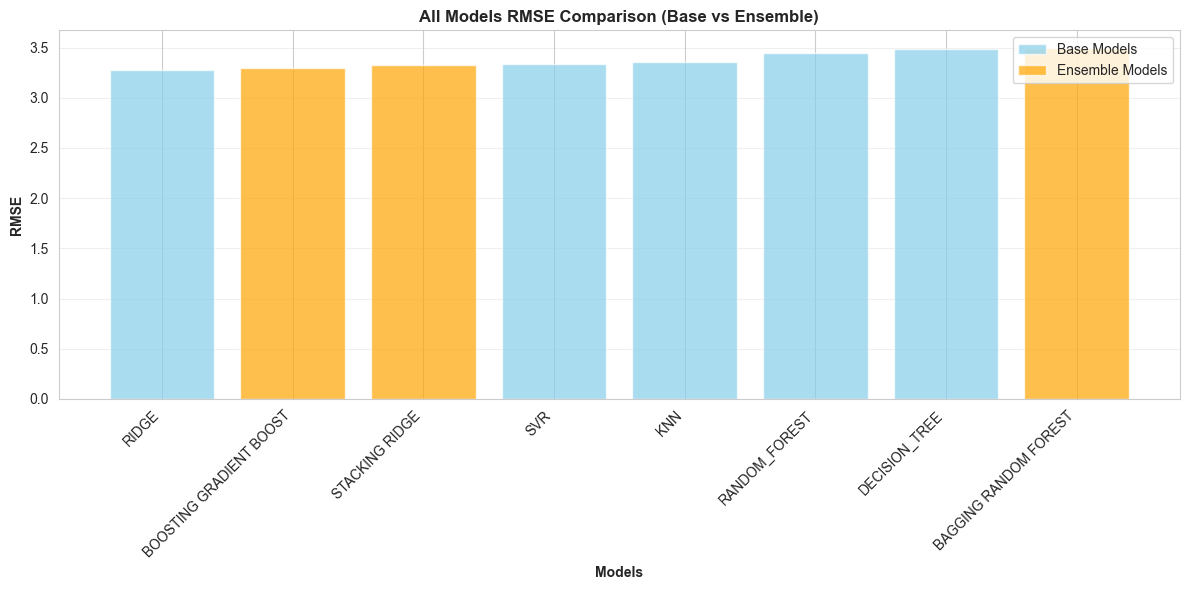


Best Overall Model: RIDGE
   Type: Base
   RMSE: 3.2724
   MAE: 2.0678


In [ ]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ All libraries imported successfully")

# Cell 2: Load Data and Base Models
X_train = np.load('../preprocessed_dataset/X_train.npy')
X_test = np.load('../preprocessed_dataset/X_test.npy')
y_train = np.load('../preprocessed_dataset/y_train.npy')
y_test = np.load('../preprocessed_dataset/y_test.npy')

# Load base models
base_models = {}
for model_name in ['knn', 'decision_tree', 'random_forest', 'svr', 'ridge']:
    base_models[model_name] = joblib.load(f'../saved_base_models_dataset/{model_name}_model.pkl')

print(f"📊 Data Loaded:")
print(f"   Training: {X_train.shape}, Test: {X_test.shape}")
print(f"✅ Base models loaded: {list(base_models.keys())}")

# Cell 3: Create Ensemble Models
ensemble_models = {
    'bagging_random_forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        bootstrap=True
    ),
    'boosting_gradient_boost': GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ),
    'stacking_ridge': StackingRegressor(
        estimators=[
            ('random_forest', base_models['random_forest']),
            ('ridge', base_models['ridge'])
        ],
        final_estimator=Ridge(alpha=1.0),
        cv=5,
        n_jobs=-1
    )
}

print("Ensemble Models Created:")
for name in ensemble_models.keys():
    print(f"   {name.replace('_', ' ').upper()}")

# Cell 4: Train Ensemble Models with 10-Fold CV
X_full = np.vstack([X_train, X_test])
y_full = np.concatenate([y_train, y_test])
cv = KFold(n_splits=10, shuffle=True, random_state=42)

ensemble_results = {}

print("=" * 70)
print("TRAINING ENSEMBLE MODELS WITH 10-FOLD CROSS-VALIDATION")
print("=" * 70)

for name, model in ensemble_models.items():
    print(f"\n[MODEL] Training {name.upper()} with 10-fold CV...")
    
    fold_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    
    cv_mse_scores = -fold_scores
    cv_mean = np.mean(cv_mse_scores)
    cv_std = np.std(cv_mse_scores)
    cv_rmse = np.sqrt(cv_mean)
    
    model.fit(X_train, y_train)
    
    # Test predictions
    y_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    
    ensemble_results[name] = {
        'model': model,
        'cv_mse_mean': cv_mean,
        'cv_mse_std': cv_std,
        'cv_rmse': cv_rmse,
        'cv_10fold_scores': fold_scores.tolist(),
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'y_pred': y_pred
    }
    
    print(f"   ✅ {name.replace('_', ' ').upper()} Trained")
    print(f"      10-Fold CV RMSE: {cv_rmse:.4f}")
    print(f"      Test RMSE: {test_rmse:.4f}")
    print(f"      Test R²: {test_r2:.4f}")

# Cell 5: Compare Ensemble Models
summary_data = []
for name, data in ensemble_results.items():
    summary_data.append({
        'Model': name.replace('_', ' ').upper(),
        'CV RMSE': f"{data['cv_rmse']:.4f}",
        'Test RMSE': f"{data['test_rmse']:.4f}",
        'Test MAE': f"{data['test_mae']:.4f}",
        'Test R²': f"{data['test_r2']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "=" * 70)
print("ENSEMBLE MODEL PERFORMANCE SUMMARY")
print("=" * 70)
display(summary_df)

print("\n" + "=" * 70)
print("DETAILED ENSEMBLE TEST RESULTS")
print("=" * 70)

sorted_models = sorted(ensemble_results.items(), key=lambda x: x[1]['test_rmse'])

print(f"\n{'Rank':<5} {'Model':<30} {'Test RMSE':<12} {'CV RMSE':<12} {'R²':<10}")
print("-" * 70)

for rank, (name, data) in enumerate(sorted_models, 1):
    print(f"{rank:<5} {name.replace('_', ' ').upper():<30} "
          f"{data['test_rmse']:<12.4f} {data['cv_rmse']:<12.4f} {data['test_r2']:<10.4f}")

best_model = sorted_models[0]
print(f"\nBest Ensemble Model: {best_model[0].replace('_', ' ').upper()}")
print(f"   Test RMSE: {best_model[1]['test_rmse']:.4f}")
print(f"   Test R²: {best_model[1]['test_r2']:.4f}")
print(f"   10-Fold CV RMSE: {best_model[1]['cv_rmse']:.4f}")

# Cell 5.5: Detailed Ensemble Predictions Analysis
print("\n" + "=" * 70)
print("ENSEMBLE TEST PREDICTIONS ANALYSIS")
print("=" * 70)

for name, data in ensemble_results.items():
    y_pred = data['y_pred']
    
    prediction_details = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Error': y_test - y_pred,
        'Absolute_Error': np.abs(y_test - y_pred),
        'Percent_Error': np.abs((y_test - y_pred) / y_test) * 100
    })
    
    print(f"\n{name.replace('_', ' ').upper()}")
    print(f"   Total Test Samples: {len(y_test)}")
    print(f"   Test RMSE: {data['test_rmse']:.4f}")
    print(f"   Test MAE:  {data['test_mae']:.4f}")
    print(f"   Test R²:   {data['test_r2']:.4f}")
    print(f"   10-Fold CV RMSE: {data['cv_rmse']:.4f}")
    
    residuals = y_test - y_pred
    print(f"   Mean Residual: {np.mean(residuals):.4f}")
    print(f"   Std Residual:  {np.std(residuals):.4f}")
    
    print(f"\n   Error Statistics:")
    print(f"   Mean Absolute Error: {prediction_details['Absolute_Error'].mean():.4f}")
    print(f"   Median Absolute Error: {prediction_details['Absolute_Error'].median():.4f}")
    print(f"   Max Error: {prediction_details['Absolute_Error'].max():.4f}")
    print(f"   Min Error: {prediction_details['Absolute_Error'].min():.4f}")
    
    print(f"\n   First 10 predictions:")
    print(prediction_details.head(10).to_string(index=False))
    
    large_errors = prediction_details[prediction_details['Absolute_Error'] > data['test_rmse']]
    if len(large_errors) > 0:
        print(f"\n   Samples with error > RMSE ({len(large_errors)} samples):")
        print(large_errors.head(5).to_string(index=False))
    
    csv_file = f'../saved_ensemble_models_dataset/{name}_test_predictions.csv'
    prediction_details.to_csv(csv_file, index=False)
    print(f"\n   Saved detailed predictions: {csv_file}")

# Cell 6: Visualize Ensemble Performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

model_names = list(ensemble_results.keys())
colors = ['#f59e0b', '#10b981', '#8b5cf6']

# Plot 1: RMSE Comparison between CV and Test
x = np.arange(len(model_names))
width = 0.35

cv_rmse = [ensemble_results[name]['cv_rmse'] for name in model_names]
test_rmse = [ensemble_results[name]['test_rmse'] for name in model_names]

axes[0, 0].bar(x - width/2, cv_rmse, width, label='CV RMSE', color=colors, alpha=0.8)
axes[0, 0].bar(x + width/2, test_rmse, width, label='Test RMSE', color=colors, alpha=0.5)
axes[0, 0].set_xlabel('Ensemble Models', fontweight='bold')
axes[0, 0].set_ylabel('RMSE', fontweight='bold')
axes[0, 0].set_title('RMSE Comparison', fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels([n.replace('_', ' ').upper() for n in model_names], rotation=15, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: R² Score Comparison
r2_scores = [ensemble_results[name]['test_r2'] for name in model_names]
axes[0, 1].bar([n.replace('_', ' ').upper() for n in model_names], r2_scores, 
               color=colors, alpha=0.8)
axes[0, 1].set_ylabel('R² Score', fontweight='bold')
axes[0, 1].set_title('R² Score Comparison', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Plot 3 & 4: Prediction vs Actual 
sorted_models = sorted(model_names, key=lambda x: ensemble_results[x]['test_r2'], reverse=True)
for idx, name in enumerate(sorted_models[:2]):
    y_pred = ensemble_results[name]['y_pred']
    
    axes[1, idx].scatter(y_test, y_pred, alpha=0.6, color=colors[idx])
    
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[1, idx].plot([min_val, max_val], [min_val, max_val], 
                      'r--', linewidth=2, label='Perfect')
    
    axes[1, idx].set_xlabel('Actual', fontweight='bold')
    axes[1, idx].set_ylabel('Predicted', fontweight='bold')
    axes[1, idx].set_title(f'{name.replace("_", " ").upper()}\nR²: {ensemble_results[name]["test_r2"]:.3f}',
                          fontweight='bold')
    axes[1, idx].legend()
    axes[1, idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 7: Save Ensemble Models
os.makedirs('../saved_ensemble_models_dataset', exist_ok=True)

for name, data in ensemble_results.items():
    joblib.dump(data['model'], f'../saved_ensemble_models_dataset/{name}_ensemble.pkl')

print("\n💾 Ensemble models saved to ../saved_ensemble_models_dataset/")

# Cell 7.5: Compare Ensemble vs Base Models
print("\n" + "=" * 70)
print("ENSEMBLE vs BASE MODELS COMPARISON")
print("=" * 70)

base_model_results = {}
for model_name in ['knn', 'decision_tree', 'random_forest', 'svr', 'ridge']:
    try:
        predictions = pd.read_csv(f'../saved_base_models_dataset/{model_name}_test_predictions.csv')
        base_model_results[model_name] = {
            'mae': predictions['Absolute_Error'].mean(),
            'rmse': np.sqrt(np.mean(predictions['Error']**2))
        }
    except:
        pass

all_results = []
for name, metrics in base_model_results.items():
    all_results.append({
        'Type': 'Base',
        'Model': name.upper(),
        'RMSE': metrics['rmse'],
        'MAE': metrics['mae']
    })

for name, data in ensemble_results.items():
    all_results.append({
        'Type': 'Ensemble',
        'Model': name.replace('_', ' ').upper(),
        'RMSE': data['test_rmse'],
        'MAE': data['test_mae']
    })

comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.sort_values('RMSE')

print("\n" + comparison_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 6))

base_models_df = comparison_df[comparison_df['Type'] == 'Base']
ensemble_df = comparison_df[comparison_df['Type'] == 'Ensemble']

x = np.arange(len(comparison_df))
width = 0.35

colors = ['skyblue' if t == 'Base' else 'orange' for t in comparison_df['Type']]
bars = ax.bar(x, comparison_df['RMSE'], color=colors, alpha=0.7)

ax.set_xlabel('Models', fontweight='bold')
ax.set_ylabel('RMSE', fontweight='bold')
ax.set_title('All Models RMSE Comparison (Base vs Ensemble)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='skyblue', alpha=0.7, label='Base Models'),
                   Patch(facecolor='orange', alpha=0.7, label='Ensemble Models')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

best_overall = comparison_df.iloc[0]
print(f"\nBest Overall Model: {best_overall['Model']}")
print(f"   Type: {best_overall['Type']}")
print(f"   RMSE: {best_overall['RMSE']:.4f}")
print(f"   MAE: {best_overall['MAE']:.4f}")